titanic_model.py

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Combine for preprocessing
data = pd.concat([train, test], sort=False)

=== Data Cleaning ===

In [4]:
# Fill missing Age with median
# data["Age"].fillna(data["Age"].median(), inplace=True)
data["Age"] = data["Age"].fillna(data["Age"].median())

In [5]:
# Fill missing Embarked with mode
# data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True)
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])

In [6]:
# Fill missing Fare with median
# data["Fare"].fillna(data["Fare"].median(), inplace=True)
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

In [7]:
# Drop Cabin due to too many missing values
data.drop("Cabin", axis=1, inplace=True)

=== Feature Engineering ===

In [8]:
# Encode Sex
data["Sex"] = data["Sex"].map({"male": 0, "female": 1})

In [9]:
# Encode Embarked
# data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

In [10]:
# Family size and is alone
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)

In [11]:
# Extract Title from Name
# data["Title"] = data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
data["Title"] = data["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare",
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", "Countess": "Rare",
    "Lady": "Rare", "Jonkheer": "Rare", "Don": "Rare", "Dona": "Rare",
    "Capt": "Rare", "Sir": "Rare"
}
data["Title"] = data["Title"].map(title_mapping)
data["Title"] = data["Title"].fillna("Rare")

In [12]:
# One-hot encode titles
title_dummies = pd.get_dummies(data["Title"], prefix="Title")
data = pd.concat([data, title_dummies], axis=1)

In [13]:
# Age bins
data["AgeBin"] = pd.cut(data["Age"], bins=[0, 12, 20, 40, 60, 80], labels=False)

=== Final Dataset Preparation ===

In [14]:
# Drop unused columns
drop_cols = ["PassengerId", "Name", "Ticket", "Title", "Age", "Fare"]
data.drop(columns=drop_cols, inplace=True)

In [15]:
# Separate back into train and test
X_train = data[:len(train)]
X_test = data[len(train):]
y_train = train["Survived"]

In [16]:
print(X_train.info())
print(X_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    int64  
 3   SibSp         891 non-null    int64  
 4   Parch         891 non-null    int64  
 5   Embarked      891 non-null    int64  
 6   FamilySize    891 non-null    int64  
 7   IsAlone       891 non-null    int64  
 8   Title_Master  891 non-null    bool   
 9   Title_Miss    891 non-null    bool   
 10  Title_Mr      891 non-null    bool   
 11  Title_Mrs     891 non-null    bool   
 12  Title_Rare    891 non-null    bool   
 13  AgeBin        891 non-null    int64  
dtypes: bool(5), float64(1), int64(8)
memory usage: 74.0 KB
None
Survived        0
Pclass          0
Sex             0
SibSp           0
Parch           0
Embarked        0
FamilySize      0
IsAlone         0
Tit

In [17]:
print(X_train.describe())

         Survived      Pclass         Sex       SibSp       Parch    Embarked  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413    0.523008    0.381594    0.361392   
std      0.486592    0.836071    0.477990    1.102743    0.806057    0.635673   
min      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    3.000000    1.000000    8.000000    6.000000    2.000000   

       FamilySize     IsAlone      AgeBin  
count  891.000000  891.000000  891.000000  
mean     1.904602    0.602694    1.914703  
std      1.613459    0.489615    0.817998  
min      1.000000    0.000000    0.000000  
25%      1.000000    0.000000    2.000000  
50%   

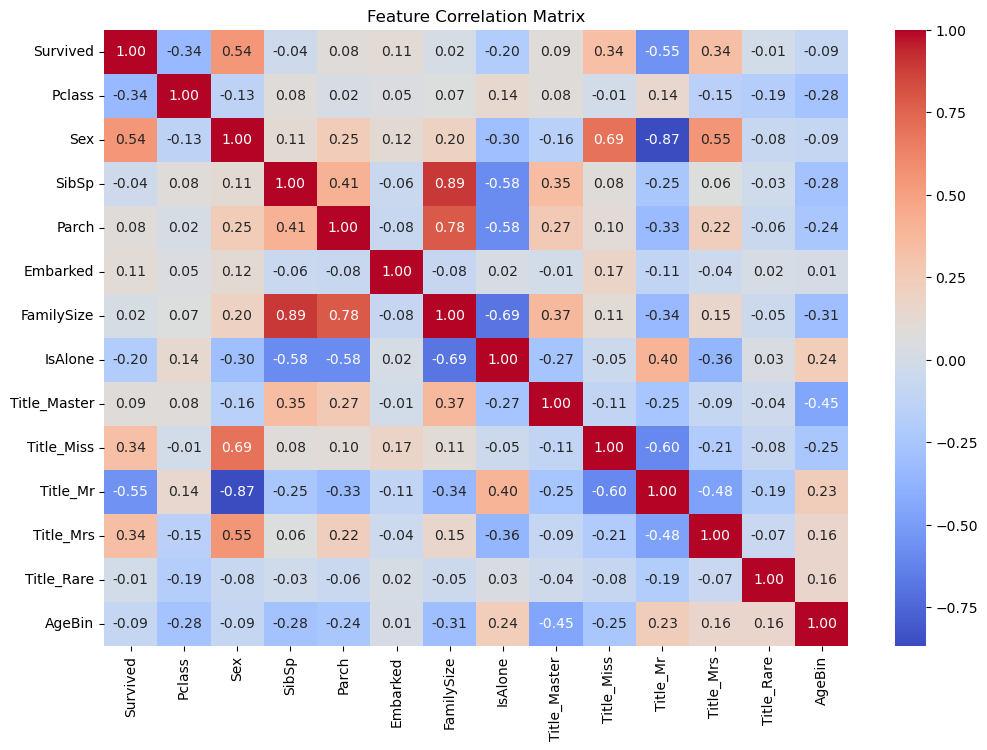

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

=== Feature Importance Plot ===

In [23]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names_plot = X_train.columns
# Plot feature importances  
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_names_plot[indices], rotation=90)
plt.tight_layout()
plt.show()

NameError: name 'rf' is not defined

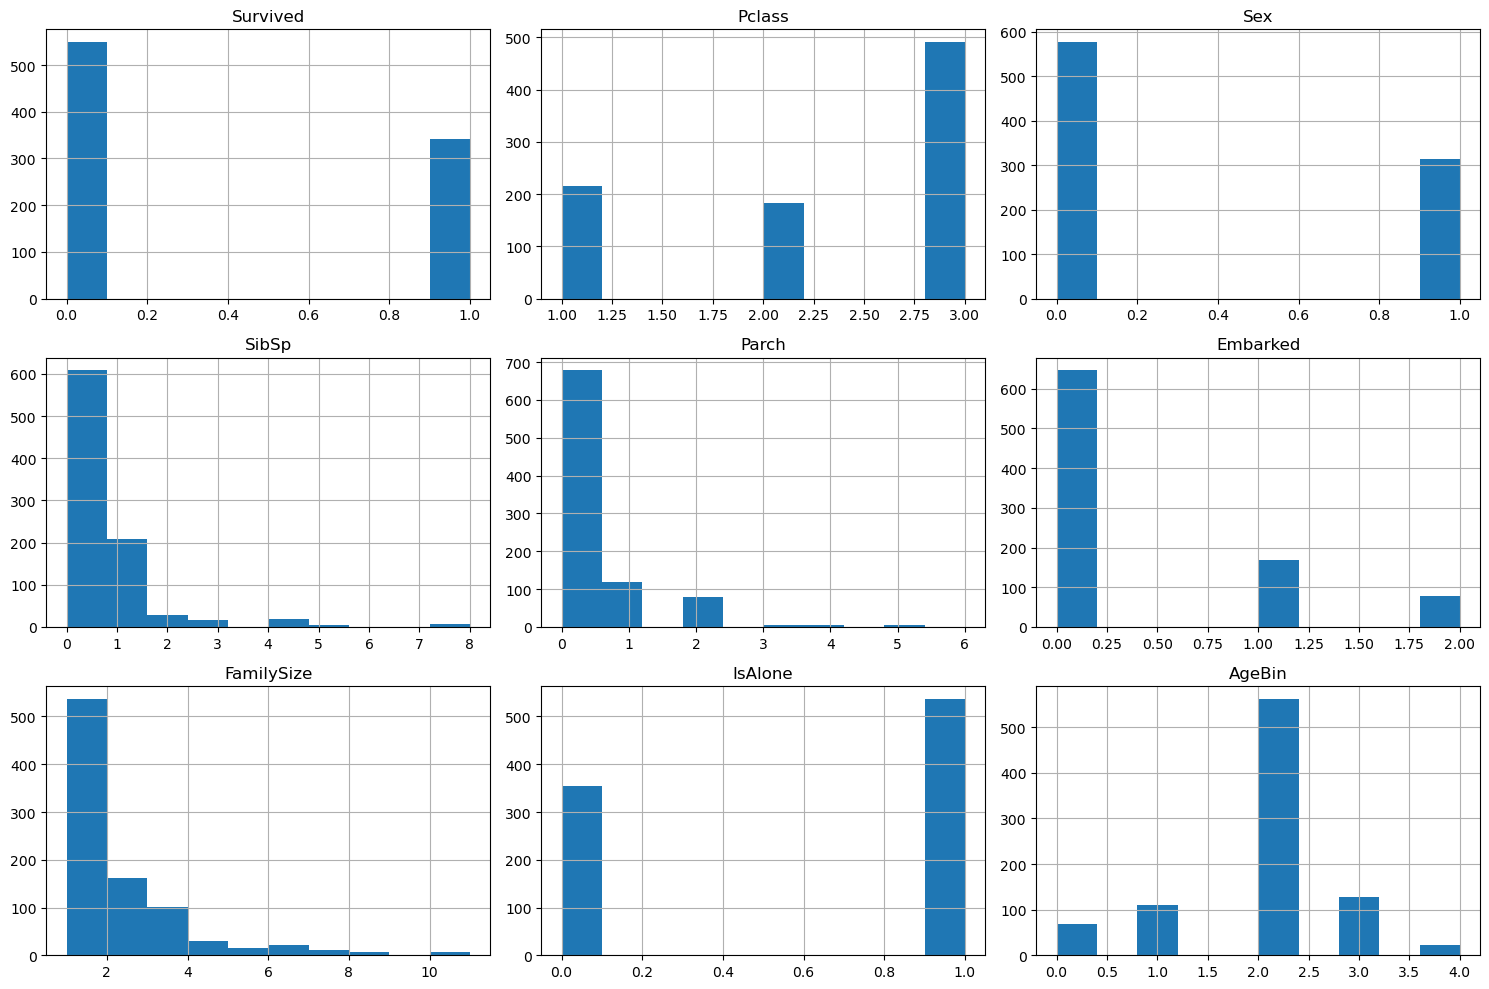

In [24]:
X_train.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

=== Modeling ===

Logistic Regression CV score: 1.0000
Random Forest CV score: 1.0000
Decision Tree CV score: 1.0000
KNN CV score: 0.9484
SVM CV score: 0.9955


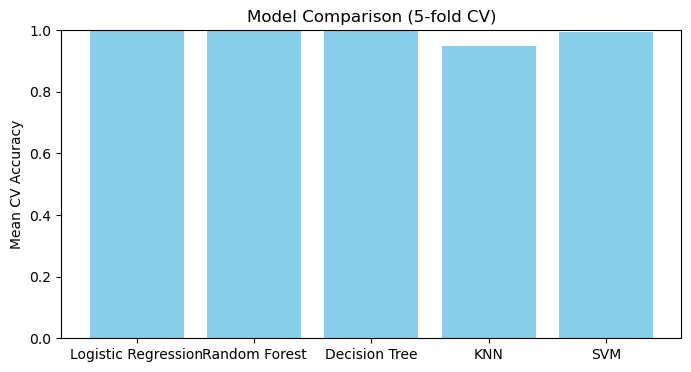

In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

cv_scores = {}
for name, model in models.items():
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    cv_scores[name] = score
    print(f"{name} CV score: {score:.4f}")

# Plot comparison
plt.figure(figsize=(8,4))
plt.bar(cv_scores.keys(), cv_scores.values(), color='skyblue')
plt.ylabel("Mean CV Accuracy")
plt.title("Model Comparison (5-fold CV)")
plt.ylim(0, 1)
plt.show()

In [26]:
# Predict on training set (or use cross_val_predict for CV predictions)
y_pred = rf.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest, Training Set)")
plt.show()

NameError: name 'rf' is not defined

In [27]:
print(classification_report(y_train, y_pred))

NameError: name 'y_pred' is not defined

In [16]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_score = cross_val_score(lr, X_train, y_train, cv=5).mean()
print(f"Logistic Regression CV score: {lr_score:.4f}")

Logistic Regression CV score: 1.0000


In [28]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_score = cross_val_score(rf, X_train, y_train, cv=5).mean()
print(f"Random Forest CV score: {rf_score:.4f}")

Random Forest CV score: 1.0000


In [41]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt_score = cross_val_score(dt, X_train, y_train, cv=5).mean()
print(f"Decision Tree CV score: {dt_score:.4f}")

Decision Tree CV score: 1.0000


In [38]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_score = cross_val_score(knn, X_train, y_train, cv=5).mean()
print(f"KNN CV score: {knn_score:.4f}")

KNN CV score: 0.9484


In [42]:
# SVM
svm = SVC()
svm_score = cross_val_score(svm, X_train, y_train, cv=5).mean()
print(f"SVM CV score: {svm_score:.4f}")

SVM CV score: 0.9955


In [43]:
# Train final model and predict
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

=== Submission ===

In [20]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
